In [17]:
import os
import re
import datetime
import pandas as pd
import numpy as np
import json
import geopandas as gpd
import dask_geopandas as dgd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely import box
import datashader as ds
from tqdm import tqdm
from dotenv import load_dotenv
import dask.dataframe as dd
import dask.distributed
import dask_gateway
from dask.distributed import PipInstall, CondaInstall, WorkerPlugin, Client, get_worker
from dask import delayed
from shapely.affinity import rotate
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, export_png, save
from bokeh.models import ColumnDataSource, Range1d, LinearAxis


In [ ]:
gateway = dask_gateway.Gateway()
cluster_options = gateway.cluster_options()
cluster = gateway.new_cluster(cluster_options)
cluster.adapt(minimum=1, maximum=100)
client = dask.distributed.Client(cluster)
client


In [3]:
# Loading data from Azure Blob Storage
%load_ext dotenv
load_dotenv()

folder_name = '202205_202209_drought_velocity_profiles'
pathname = 'abfs://ais/parquet/' + folder_name 
sas_token2 = os.environ['SAS_TOKEN2']


ddf = dd.read_parquet(pathname, 
                      engine='pyarrow',
                      storage_options={"account_name": "rwsais", "sas_token": sas_token2})


### Single trajectory extraction for plotting in QGIS

In [90]:
traj_id = 19454

traj_id_df = ddf[ddf['traj_id'] == traj_id].compute()

In [93]:
traj_id_gdf = gpd.GeoDataFrame(traj_id_df, geometry=gpd.points_from_xy(traj_id_df.longitude, traj_id_df.latitude))
traj_id_gdf.to_file('traj_right.geojson', driver='GeoJSON') 

## Crossing zones

In [25]:
polygon_gdf = gpd.read_file('box_trein_big.geojson')
polygon_train = polygon_gdf.geometry[0]


In [26]:
polygon_oversteek = gpd.read_file('oversteek_goed.geojson')
polygon_oversteek = polygon_oversteek.geometry[0]

In [27]:
polygon_waalbrug = gpd.read_file('box_waalbrug.geojson')
polygon_waalbrug = polygon_waalbrug.geometry[0]

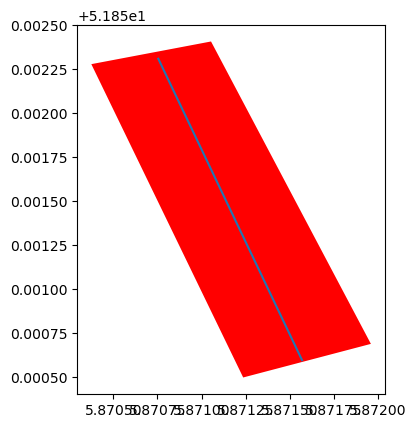

In [76]:

# set which bridge
polygon = polygon_waalbrug

if polygon == polygon_oversteek:
    angle = -33
elif polygon == polygon_train:
    angle = -28
else:
    angle = 25.5

centroid = polygon.centroid
minx, miny, maxx, maxy = polygon.bounds
orientation_line = LineString([(centroid.x, miny), (centroid.x, maxy)])
orientation_line


new_line = rotate(orientation_line, angle, origin=centroid, use_radians=False)
# show new_line and polygon in same plot
fig, ax = plt.subplots()
gpd.GeoSeries([new_line]).plot(ax=ax)
gpd.GeoSeries([polygon]).plot(ax=ax, color='red')
plt.show()

In [77]:
from shapely.affinity import rotate

def filter_within_polygon(partition, polygon, angle):
    """Apply spatial filter to a partition of data, add signed lateral positions relative to polygon centroid."""
    # Convert the partition to a GeoDataFrame
    gdf = gpd.GeoDataFrame(partition, geometry=gpd.points_from_xy(partition.longitude, partition.latitude))
    
    # Perform spatial filtering
    filtered_gdf = gdf[gdf.geometry.within(polygon)]
        
    # Calculate the centroid and main orientation of the polygon
    centroid = polygon.centroid
    minx, miny, maxx, maxy = polygon.bounds

     # Create a reference line from north to south through the centroid
    orientation_line = LineString([(centroid.x, miny), (centroid.x, maxy)])
    # Rotate the orientation line by the specified angle around the centroid
    rotated_orientation_line = rotate(orientation_line, angle, origin=centroid)

    # Calculate signed lateral positions relative to the rotated orientation line
    # Project each point onto the rotated orientation line and calculate distance from centroid
    def calculate_signed_distance(geom):
        # Rotate the point by the same angle to align with the rotated orientation line
        rotated_point = rotate(geom, angle, origin=centroid)
        
        # Project the rotated point onto the rotated orientation line
        projected_point = rotated_orientation_line.interpolate(rotated_orientation_line.project(rotated_point))
        
        # Calculate the distance from the projected point to the centroid
        distance = projected_point.distance(centroid)
        
        # Determine the sign based on the y-coordinate of the projected point
        sign = 1 if projected_point.y < centroid.y else -1
        
        # Return the signed distance
        return sign * distance*111000

    # Apply the function to calculate lateral positions
    filtered_gdf['lateral_pos'] = filtered_gdf['geometry'].apply(calculate_signed_distance)
    
    return filtered_gdf

existing_meta = ddf.dtypes.to_dict()
new_meta = {'geometry': 'object',
            #'rotated_geometry': 'object',
            'lateral_pos': 'float64'
            }
    
full_meta = {**existing_meta, **new_meta}

ddf_within = ddf.map_partitions(filter_within_polygon, polygon=polygon, angle=angle, meta=full_meta)
ddf_within.head()

,sog,cog,rot,longitude,latitude,maneuver,seconds,name,draughtInland,length,width,datetime,time_diff,traj_id,distance,speed,acceleration,geometry,lateral_pos
87,5.4,73.199997,0.0,5.871022,51.850990,0,42.0,testschip-1001,0.4,110.0,12.0,2022-05-02 11:07:41+00:00,10.0,-1,41.067437,14.784277,-0.151760,POINT (5.87102 51.85099),51.342029
88,5.4,73.199997,0.0,5.871455,51.851170,0,52.0,testschip-1001,0.4,110.0,12.0,2022-05-02 11:07:53+00:00,12.0,-1,52.068469,15.620541,0.019358,POINT (5.87146 51.85117),31.440754
208,9.8,242.699997,0.0,5.870843,51.851383,0,2.0,testschip-1001,0.4,110.0,12.0,2022-05-12 04:16:02+00:00,10.0,0,83.464713,30.047297,0.092475,POINT (5.87084 51.85138),7.728596
361,4.7,71.099998,0.0,5.870788,51.851925,0,45.0,testschip-1001,0.4,110.0,12.0,2022-05-24 18:07:43+00:00,10.0,1,32.570858,11.725509,-0.043552,POINT (5.87079 51.85192),-52.398663
548,4.6,70.000000,0.0,5.870888,51.851917,0,34.0,testschip-1001,0.4,110.0,12.0,2022-06-11 09:42:33+00:00,9.0,2,34.158119,13.663247,-0.058283,POINT (5.87089 51.85192),-51.551800


In [78]:
# set index as column datetime
ddf_within = ddf_within.reset_index()
ddf_within.head()


,index,sog,cog,rot,longitude,latitude,maneuver,seconds,name,draughtInland,length,width,datetime,time_diff,traj_id,distance,speed,acceleration,geometry,lateral_pos
0,87,5.4,73.199997,0.0,5.871022,51.850990,0,42.0,testschip-1001,0.4,110.0,12.0,2022-05-02 11:07:41+00:00,10.0,-1,41.067437,14.784277,-0.151760,POINT (5.87102 51.85099),51.342029
1,88,5.4,73.199997,0.0,5.871455,51.851170,0,52.0,testschip-1001,0.4,110.0,12.0,2022-05-02 11:07:53+00:00,12.0,-1,52.068469,15.620541,0.019358,POINT (5.87146 51.85117),31.440754
2,208,9.8,242.699997,0.0,5.870843,51.851383,0,2.0,testschip-1001,0.4,110.0,12.0,2022-05-12 04:16:02+00:00,10.0,0,83.464713,30.047297,0.092475,POINT (5.87084 51.85138),7.728596
3,361,4.7,71.099998,0.0,5.870788,51.851925,0,45.0,testschip-1001,0.4,110.0,12.0,2022-05-24 18:07:43+00:00,10.0,1,32.570858,11.725509,-0.043552,POINT (5.87079 51.85192),-52.398663
4,548,4.6,70.000000,0.0,5.870888,51.851917,0,34.0,testschip-1001,0.4,110.0,12.0,2022-06-11 09:42:33+00:00,9.0,2,34.158119,13.663247,-0.058283,POINT (5.87089 51.85192),-51.551800


In [79]:
def filter_duplicates_within(partition):
    """Filter out points that have the same trajectory_id and are within 30 seconds of each other."""
    partition = partition.sort_values('datetime')

    # Group by 'traj_id' and then apply the filtering logic
    def filter_within_group(group):
        # Calculate the time difference between consecutive points
        group['time_diff'] = group['datetime'].diff().dt.total_seconds().abs()
        # Keep the first point and any point that is at least 30 seconds away from the previous point
        return group[(group['time_diff'] > 30) | (group['time_diff'].isna())]
    

    # Apply the filtering function to each group
    return partition.groupby('traj_id').apply(filter_within_group).reset_index(drop=True)
ddf_within = ddf_within.map_partitions(filter_duplicates_within, meta=ddf_within)
ddf_within.head()

,index,sog,cog,rot,longitude,latitude,maneuver,seconds,name,draughtInland,length,width,datetime,time_diff,traj_id,distance,speed,acceleration,geometry,lateral_pos
0,87,5.4,73.199997,0.0,5.871022,51.850990,0,42.0,testschip-1001,0.4,110.0,12.0,2022-05-02 11:07:41+00:00,NaN,-1,41.067437,14.784277,-0.151760,POINT (5.87102 51.85099),51.342029
1,208,9.8,242.699997,0.0,5.870843,51.851383,0,2.0,testschip-1001,0.4,110.0,12.0,2022-05-12 04:16:02+00:00,NaN,0,83.464713,30.047297,0.092475,POINT (5.87084 51.85138),7.728596
2,361,4.7,71.099998,0.0,5.870788,51.851925,0,45.0,testschip-1001,0.4,110.0,12.0,2022-05-24 18:07:43+00:00,NaN,1,32.570858,11.725509,-0.043552,POINT (5.87079 51.85192),-52.398663
3,548,4.6,70.000000,0.0,5.870888,51.851917,0,34.0,testschip-1001,0.4,110.0,12.0,2022-06-11 09:42:33+00:00,NaN,2,34.158119,13.663247,-0.058283,POINT (5.87089 51.85192),-51.551800
4,678,9.6,249.100006,0.0,5.871437,51.851662,0,32.0,testschip-1001,0.4,110.0,12.0,2022-06-22 10:22:31+00:00,NaN,3,93.963431,30.751668,0.078224,POINT (5.87144 51.85166),-23.181896


In [80]:
# First two bridges
ddf_within['upstream'] = (ddf_within['cog'] > 30) & (ddf_within['cog'] < 210)

#third brige between 30 and 160
#ddf_within['upstream'] = (ddf_within['cog'] > 30) & (ddf_within['cog'] < 160)   


In [81]:
# Create two separate dask dataframes where one is in period of 01-05-2022 until 1-07-2022 and the other one from 15-07-2022 to 15-08-2022
normal_period_ddf = ddf_within[(ddf_within['datetime'] >= '2022-05-01') & (ddf_within['datetime'] < '2022-07-01')]
drought_period_ddf = ddf_within[(ddf_within['datetime'] >= '2022-07-01') & (ddf_within['datetime'] < '2022-08-31')]


In [82]:
normal_period_df = normal_period_ddf.compute()
drought_period_df = drought_period_ddf.compute()    

### Data inspection

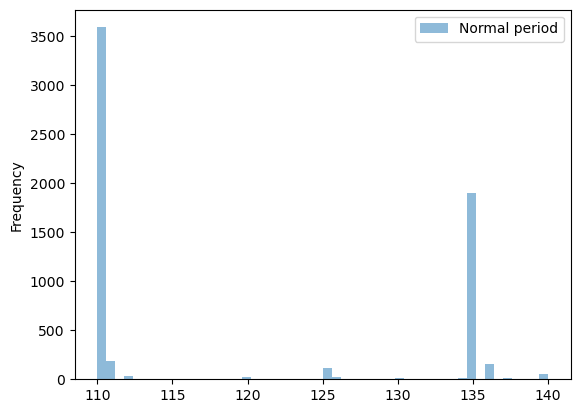

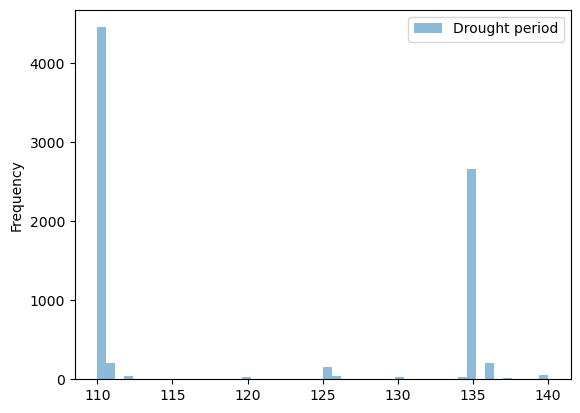

In [83]:
# plot distribution of length for normal_period_ddf and drought_period_ddf
fig, ax = plt.subplots()
normal_period_df['length'].plot.hist(ax=ax, bins=50, alpha=0.5, label='Normal period')
plt.legend()
plt.show()

fig, ax = plt.subplots()
drought_period_df['length'].plot.hist(ax=ax, bins=50, alpha=0.5, label='Drought period')
plt.legend()
plt.show()


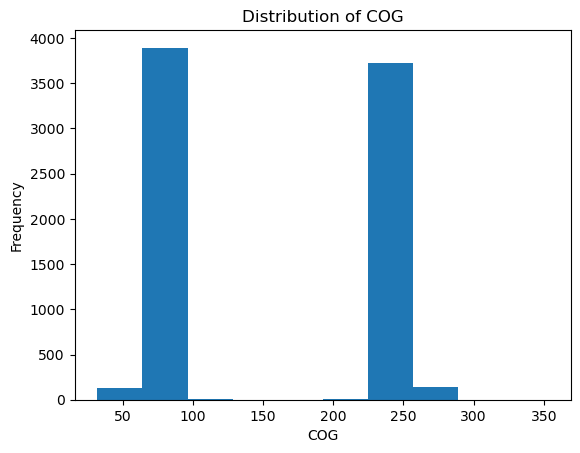

In [84]:

drought_period_df['cog'].plot.hist()
plt.title('Distribution of COG')
plt.xlabel('COG')
plt.ylabel('Frequency')
plt.show()



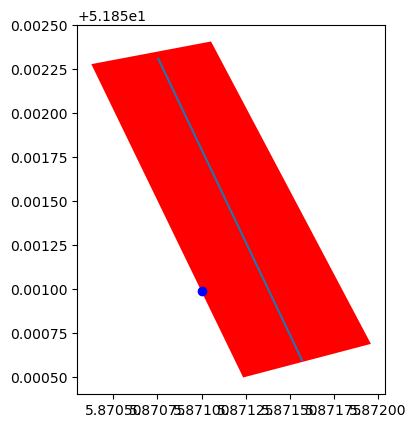

index                                                    841
sog                                                      5.1
cog                                                74.400002
rot                                                      0.0
longitude                                           5.871003
latitude                                           51.850986
maneuver                                                   0
seconds                                                 33.0
name                                          testschip-1001
draughtInland                                            0.4
length                                                 110.0
width                                                   12.0
datetime                           2022-06-24 05:08:32+00:00
time_diff                                                NaN
traj_id                                                    4
distance                                           45.374069
speed                   

In [85]:
# Plot one point with the polygon and orientation line to validate the lateral position calculation
i = 5
fig, ax = plt.subplots()
gpd.GeoSeries([polygon]).plot(ax=ax, color='red')
gpd.GeoSeries([new_line]).plot(ax=ax)
gpd.GeoSeries([Point(normal_period_df['longitude'].iloc[i], normal_period_df['latitude'].iloc[i])]).plot(ax=ax, color='blue')
plt.show()
normal_period_df.iloc[i]

### Distribution plotting

In [86]:
normal_period_df['datetime'].dt.date.nunique()

61

In [87]:
drought_period_df['datetime'].dt.date.nunique()

61

In [88]:
# Removing most severe outliers
normal_period_df = normal_period_df[normal_period_df['sog'] < normal_period_df['sog'].quantile(0.99)]
normal_period_df = normal_period_df[normal_period_df['sog'] > normal_period_df['sog'].quantile(0.01)]

In [89]:
drought_period_df = drought_period_df[drought_period_df['sog'] < drought_period_df['sog'].quantile(0.99)]
drought_period_df = drought_period_df[drought_period_df['sog'] > drought_period_df['sog'].quantile(0.01)]

In [90]:

# Ensure output is rendered correctly in your notebook
output_notebook()

def plot_lateral_distribution_and_speeds(df, title, observation_days):
    # Data preparation
    lateral_positions_upstream = df[df['upstream']]['lateral_pos']
    lateral_positions_downstream = df[~df['upstream']]['lateral_pos']

    # Define the common range and bin edges for lateral positions
    bin_edges = np.linspace(-125, 125, 51)  # 50 bins between -125 and 125

    # Compute histograms and mean speeds
    hist_up, edges_up = np.histogram(lateral_positions_upstream, bins=bin_edges)
    hist_down, edges_down = np.histogram(lateral_positions_downstream, bins=bin_edges)

    # Normalize histograms to crossings per day
    hist_up_per_day = hist_up / observation_days
    hist_down_per_day = hist_down / observation_days

    # Calculate bin widths
    bin_widths_up = np.diff(edges_up)
    bin_widths_down = np.diff(edges_down)

    # Normalize histograms to unit area
    hist_up_normalized = hist_up_per_day / (hist_up_per_day * bin_widths_up).sum()
    hist_down_normalized = hist_down_per_day / (hist_down_per_day * bin_widths_down).sum()

    # Prepare histogram data for plotting
    hist_df_up = pd.DataFrame({'hist': hist_up_normalized, 'left': edges_up[:-1], 'right': edges_up[1:]})
    hist_df_down = pd.DataFrame({'hist': hist_down_normalized, 'left': edges_down[:-1], 'right': edges_down[1:]})

    # Calculate mean speeds
    mean_speeds_up = [df.loc[(df['upstream']) & (df['lateral_pos'] >= edges_up[i]) & (df['lateral_pos'] < edges_up[i+1]), 'sog'].mean()*1.852 for i in range(len(edges_up)-1)]
    mean_speeds_down = [df.loc[(~df['upstream']) & (df['lateral_pos'] >= edges_down[i]) & (df['lateral_pos'] < edges_down[i+1]), 'sog'].mean()*1.852 for i in range(len(edges_down)-1)]

       # Create a new plot
    p = figure(title=title, x_axis_label='Lateral Position from Center', y_axis_label='Normalized Crossing Frequency')
    
    # Calculate appropriate y-ranges for histogram to make sure it's visible
    max_hist_density = max(hist_up_normalized.max(), hist_down_normalized.max()) * 1.1  # 10% padding
    p.y_range = Range1d(0, max_hist_density)  # Adjust the primary y-range to suit histogram values
    
    # Add histograms with transparency
    p.quad(bottom=0, top='hist', left='left', right='right', source=ColumnDataSource(hist_df_up), fill_color='blue', line_color='black', legend_label="Upstream", alpha=0.6)
    p.quad(bottom=0, top='hist', left='left', right='right', source=ColumnDataSource(hist_df_down), fill_color='red', line_color='black', legend_label="Downstream", alpha=0.6)


    # Define a secondary range for plotting speeds below the primary histogram
    max_hist = max(hist_up_normalized.max(), hist_down_normalized.max())
    p.extra_y_ranges = {"speed": Range1d(start=0, end=30)}
    p.add_layout(LinearAxis(y_range_name="speed", axis_label="Mean Speed (km/h)"), 'right')

    # Add mean speeds using line with inverted y-axis
    p.line(x=edges_up[:-1], y=mean_speeds_up, y_range_name="speed", color='darkblue', legend_label="Mean Speed Upstream", line_width=2)
    p.line(x=edges_down[:-1], y=mean_speeds_down, y_range_name="speed", color='darkred', legend_label="Mean Speed Downstream", line_width=2)

    # Customizations
    p.grid.grid_line_alpha = 0.3
    p.title.align = 'center'
    p.legend.label_text_font_size = '10pt'  # Change '8pt' to any other appropriate size
    p.legend.padding = 5  # Reduce padding; default is 10
    p.legend.margin = 5   # Reduce margin around the legend

    p.line(x=[0, 0], y=[0, max_hist], line_width=2, color='red', line_dash='dotted')
    
    p.line(x=[-110, -110], y=[0, max_hist], line_width=2, color='black')
    p.line(x=[110, 110], y=[0, max_hist], line_width=2, color='black')
    # Title font
    p.title.text_font_size = '11pt'
    p.title.text_font = "Arial"
    p.title.text_color = "black"
    
    # Axis labels
    p.xaxis.axis_label_text_font_size = '12pt'
    p.xaxis.axis_label_text_font_style = 'bold'
    p.yaxis.axis_label_text_font_size = '12pt'
    p.yaxis.axis_label_text_font_style = 'bold'
    
    # Axis major labels (ticks)
    p.xaxis.major_label_text_font_size = '10pt'
    p.yaxis.major_label_text_font_size = '10pt'
    
    # Legend font
    p.legend.label_text_font_size = '10pt'
    p.legend.label_text_font = "Arial"

    p.toolbar_location = None 


    # Display the plot
    show(p)
    return(p)
    

# Example usage, assuming you know the number of days of each dataset
p = plot_lateral_distribution_and_speeds(df=normal_period_df, title='Distribution of Ship Crossings with Speeds - Normal Period (May-June 2022)', observation_days=61)
#save(p, filename="distrib_spoor_normal.html")

p = plot_lateral_distribution_and_speeds(df=drought_period_df, title='Distribution of Ship Crossings with Speeds Drought Period (July-August 2022)  ', observation_days=61)

#save(p, filename="distrib_spoor_drought.html")



Loading BokehJS ...

In [94]:
### G test

In [93]:
import numpy as np
import pandas as pd
from scipy.stats import power_divergence

# Assuming drought_period_df and normal_period_df are already defined
upstream_drought = drought_period_df.loc[drought_period_df['upstream'] == True]
upstream_normal = normal_period_df.loc[normal_period_df['upstream'] == True]

def prepare_histogram_data(df, bins=50):
    hist, bin_edges = np.histogram(df['lateral_pos'], bins=bins)
    return hist, bin_edges

# Generate histograms for drought and normal periods
hist_drought, bin_edges_drought = prepare_histogram_data(upstream_drought, bins=50)
hist_normal, bin_edges_normal = prepare_histogram_data(upstream_normal, bins=50)

bin_edges = np.linspace(min(bin_edges_drought[0], bin_edges_normal[0]), 
                        max(bin_edges_drought[-1], bin_edges_normal[-1]), 
                        len(bin_edges_drought))
hist_drought, _ = np.histogram(upstream_drought['lateral_pos'], bins=bin_edges)
hist_normal, _ = np.histogram(upstream_normal['lateral_pos'], bins=bin_edges)

# Combine the histograms into a contingency table
observed = np.array([hist_drought, hist_normal])

# Calculate the expected frequencies assuming no difference between periods
total_drought = hist_drought.sum()
total_normal = hist_normal.sum()
total = total_drought + total_normal

# Expected frequencies based on the null hypothesis
expected_drought = (hist_drought + hist_normal) * (total_drought / total)
expected_normal = (hist_drought + hist_normal) * (total_normal / total)

# Combine expected frequencies into the same structure as observed
expected = np.where(expected == 0, 1e-10, expected)

# Check for zero expected frequencies
if np.any(expected == 0):
    print("Warning: Zero expected frequencies found!")
    expected = np.where(expected == 0, 1e-10, expected)  # Avoid zero expected frequencies

# Perform the G-test on the contingency table
g_stat, p_value = power_divergence(f_obs=observed.flatten(), f_exp=expected.flatten(), lambda_='log-likelihood')

# Calculate degrees of freedom
dof = (observed.shape[0] - 1) * (observed.shape[1] - 1)

print(f'G-test statistic: {g_stat}')
print(f'p-value: {p_value}')
print(f'Degrees of freedom: {dof}')
print(f'Observed frequencies:\n{observed}')
print(f'Expected frequencies:\n{expected}')


G-test statistic: 831.7850524212653
p-value: 3.285123495596507e-116
Degrees of freedom: 49
Observed frequencies:
[[  0   0   1   1   2   5   8  20  21  46  75  82 104 145 124 169 149  75
  118  90  75  66  61  47  38  37  29  25  27  29  27  38  31  57  91  84
  122 208 200 259 282 244 261 171  91  76  30   5   2   0]
 [  1   1   0   1   4   9  21  26  44 101 132 119 165 202 162 181 151 103
  147  96  66  58  45  27  38  17  18  21   7  11   8  12  18  25  31  30
   50  55  66  78 118 124 149 146  90  78  46  19  11   3]]
Expected frequencies:
[[  1.67311767   1.67311767   1.67311767   3.90394123   8.92329425
   16.73117672  23.9813533   45.73188303  61.34764797 107.07953101
  120.46447238 136.63794321 167.86947309 180.69670857 171.77341432
  153.92682582 138.31106088 107.6372369  127.71464896  94.25229552
   67.48241277  60.23223619  51.30894194  32.90464755  41.8279418
   27.32758864  20.07741206  25.65447097  20.07741206  17.8465885
   22.30823563  25.09676508  30.1161181   42.38564

### Bathymetry

Possibility to add bathymetry values but not used

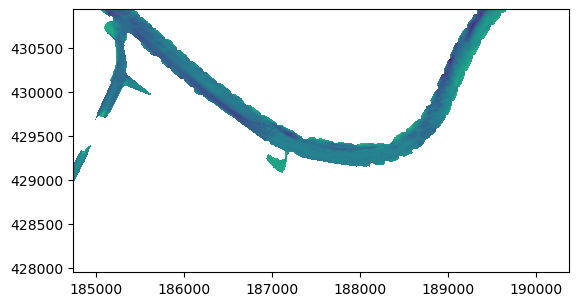

<Axes: >

In [137]:
import rasterio
from rasterio.plot import show

# Load the GeoTIFF file
bathymetry_path = 'bathy_right.tif'
bathymetry = rasterio.open(bathymetry_path)

# Show the bathymetry map (optional)
show(bathymetry)

In [140]:
# normal and drought df to gdf
def to_geodataframe(df):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
normal_gdf = to_geodataframe(normal_period_df)
drought_gdf = to_geodataframe(drought_period_df)    

In [146]:
bathymetry_crs = bathymetry.crs
# give AIS crs their WGS84

normal_gdf.crs = 'EPSG:4326'
drought_gdf.crs = 'EPSG:4326'

# Change to bathymetry crs
normal_gdf = normal_gdf.to_crs(bathymetry_crs)
drought_gdf = drought_gdf.to_crs(bathymetry_crs)


In [148]:
def extract_bathymetry_values(raster, gdf):
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    bathymetry_values = []

    for coord in coords:
        row, col = raster.index(coord[0], coord[1])
        bathymetry_values.append(raster.read(1)[row, col])

    return bathymetry_values

# Extract bathymetry values for AIS points
drought_gdf['bathymetry'] = extract_bathymetry_values(bathymetry, drought_gdf)
normal_gdf['bathymetry'] = extract_bathymetry_values(bathymetry, normal_gdf)

In [150]:
# save the drought and normal gdf
drought_gdf.to_file('drought_gdf.geojson', driver='GeoJSON')
normal_gdf.to_file('normal_gdf.geojson', driver='GeoJSON')
# plot the bathymetry column using the geometry column as well
fig, ax = plt.subplots()
drought_gdf.plot(column='bathymetry', ax=ax, legend=True)
plt.show()

fig, ax = plt.subplots()
normal_gdf.plot(column='bathymetry', ax=ax, legend=True)
plt.show()


##  Discharge Data

In [137]:
# Debiet / Current
debiet_xlsx = pd.read_excel('debiet.xlsx')

debiet = debiet_xlsx[['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)', 'LOCATIE_CODE', 'ALFANUMERIEKEWAARDE']]

debiet.loc[:, 'datetime'] = pd.to_datetime(debiet['WAARNEMINGDATUM'].astype(str) + ' ' + debiet['WAARNEMINGTIJD (MET/CET)'].astype(str))

# Drop the original separate date and time columns
debiet.drop(columns=['WAARNEMINGDATUM', 'WAARNEMINGTIJD (MET/CET)'], inplace=True)

count = (debiet['ALFANUMERIEKEWAARDE'] == .999999E+38).sum()

print("Number of instances with value .999999E+38:", count)

debiet = debiet[(debiet['ALFANUMERIEKEWAARDE'] != .999999E+38) & (debiet['ALFANUMERIEKEWAARDE'] != 0) & (debiet['LOCATIE_CODE']== "LOBH")]

# Convert to Dask DataFrame
#debiet = dd.from_pandas(debiet, npartitions=10)

# Convert the 'datetime' column to datetime using the specified format
debiet['datetime'] = pd.to_datetime(debiet['datetime'])



Number of instances with value .999999E+38: 199


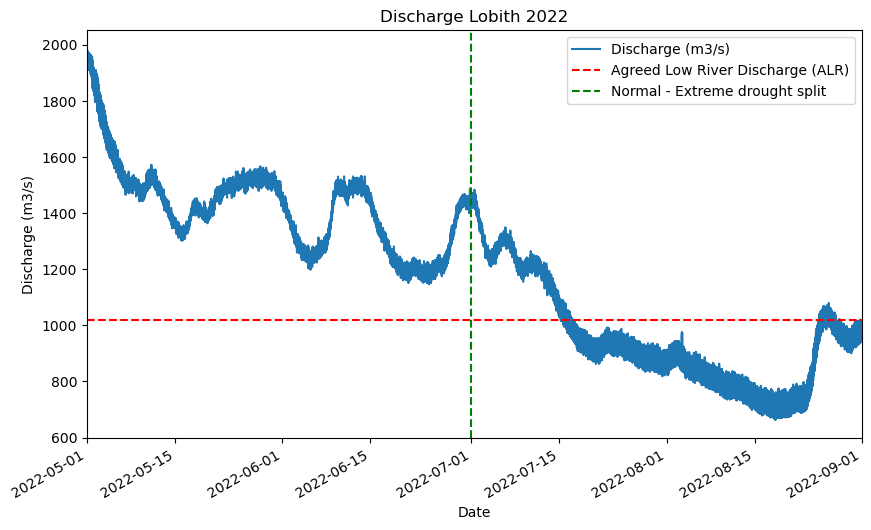

In [154]:
# make a plot of the debiet (ALFANUMERIEKEWAARDE) over time
debiet = debiet.set_index('datetime')

debiet = debiet.reset_index()

fig, ax = plt.subplots(figsize=(10, 6))
debiet.plot(x='datetime', y='ALFANUMERIEKEWAARDE', ax=ax,  label='Discharge (m3/s)')
ax.set_title('Discharge Lobith 2022')
ax.set_ylabel('Discharge (m3/s)')
ax.set_xlabel('Date')
ax.axhline(y=1020, color='r', linestyle='--', label='Agreed Low River Discharge (ALR)')
ax.axvline(x=pd.to_datetime('2022-07'), color='g', linestyle='--', label='Normal - Extreme drought split')

ax.legend()
ax.set_xlim( left=pd.to_datetime('2022-05-01'), right=pd.to_datetime('2022-09'))
plt.show()

In [ ]:
# Example of setting 'datetime' as the index and ensuring it is sorted
debiet['datetime'] = dd.to_datetime(debiet['datetime'])

# Set datetime as the index and sort
ddf = ddf.set_index('datetime')
debiet = debiet.set_index('datetime')

In [21]:
# Possibility to add Discharge data to dask dataframes
def add_debiet_to_ais(ais_df, debiet_df):
    # Perform an asof merge using the indices
    merged_df = dd.merge_asof(ais_df, debiet_df, left_index=True, right_index=True, direction='nearest')

    # Rename and clean up
    merged_df = merged_df.rename(columns={'ALFANUMERIEKEWAARDE': 'discharge'})

    return merged_df

# Assuming ais_gdf and debiet are Dask DataFrames
#df['datetime'] = df['datetime'].dt.tz_localize(None)

ddf_dis = add_debiet_to_ais(ddf, debiet)
ddf_dis = ddf_dis.persist()